In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [2]:
movies = pd.read_csv('movies.csv')

In [3]:
movies['metascore'] = pd.to_numeric(movies['metascore'])
movies['month'] = pd.to_numeric(movies['release_date.month'])
movies['votes'] = pd.to_numeric(movies['votes'])
movies['gross'] = pd.to_numeric(movies['gross'])

In [4]:
movies_new = movies[['year', 'movie', 'certificate', 'genre', 'duration', 'rate', 'metascore', 'votes', 'gross', 
                   'release_date', 'user_reviews', 'critic_reviews', 'popularity', 'awards_wins', 'awards_nominations',
                   'Oscar_nominated', 'month']]

new_movies_new = movies_new.loc[movies['certificate'] != 'Not Rated']
new_movies_new = new_movies_new.loc[movies['certificate'] != 'TV-MA']


np.random.seed(2)
train = new_movies_new.sample(round(movies_new.shape[0]*0.6))
test = new_movies_new.drop(train.index)

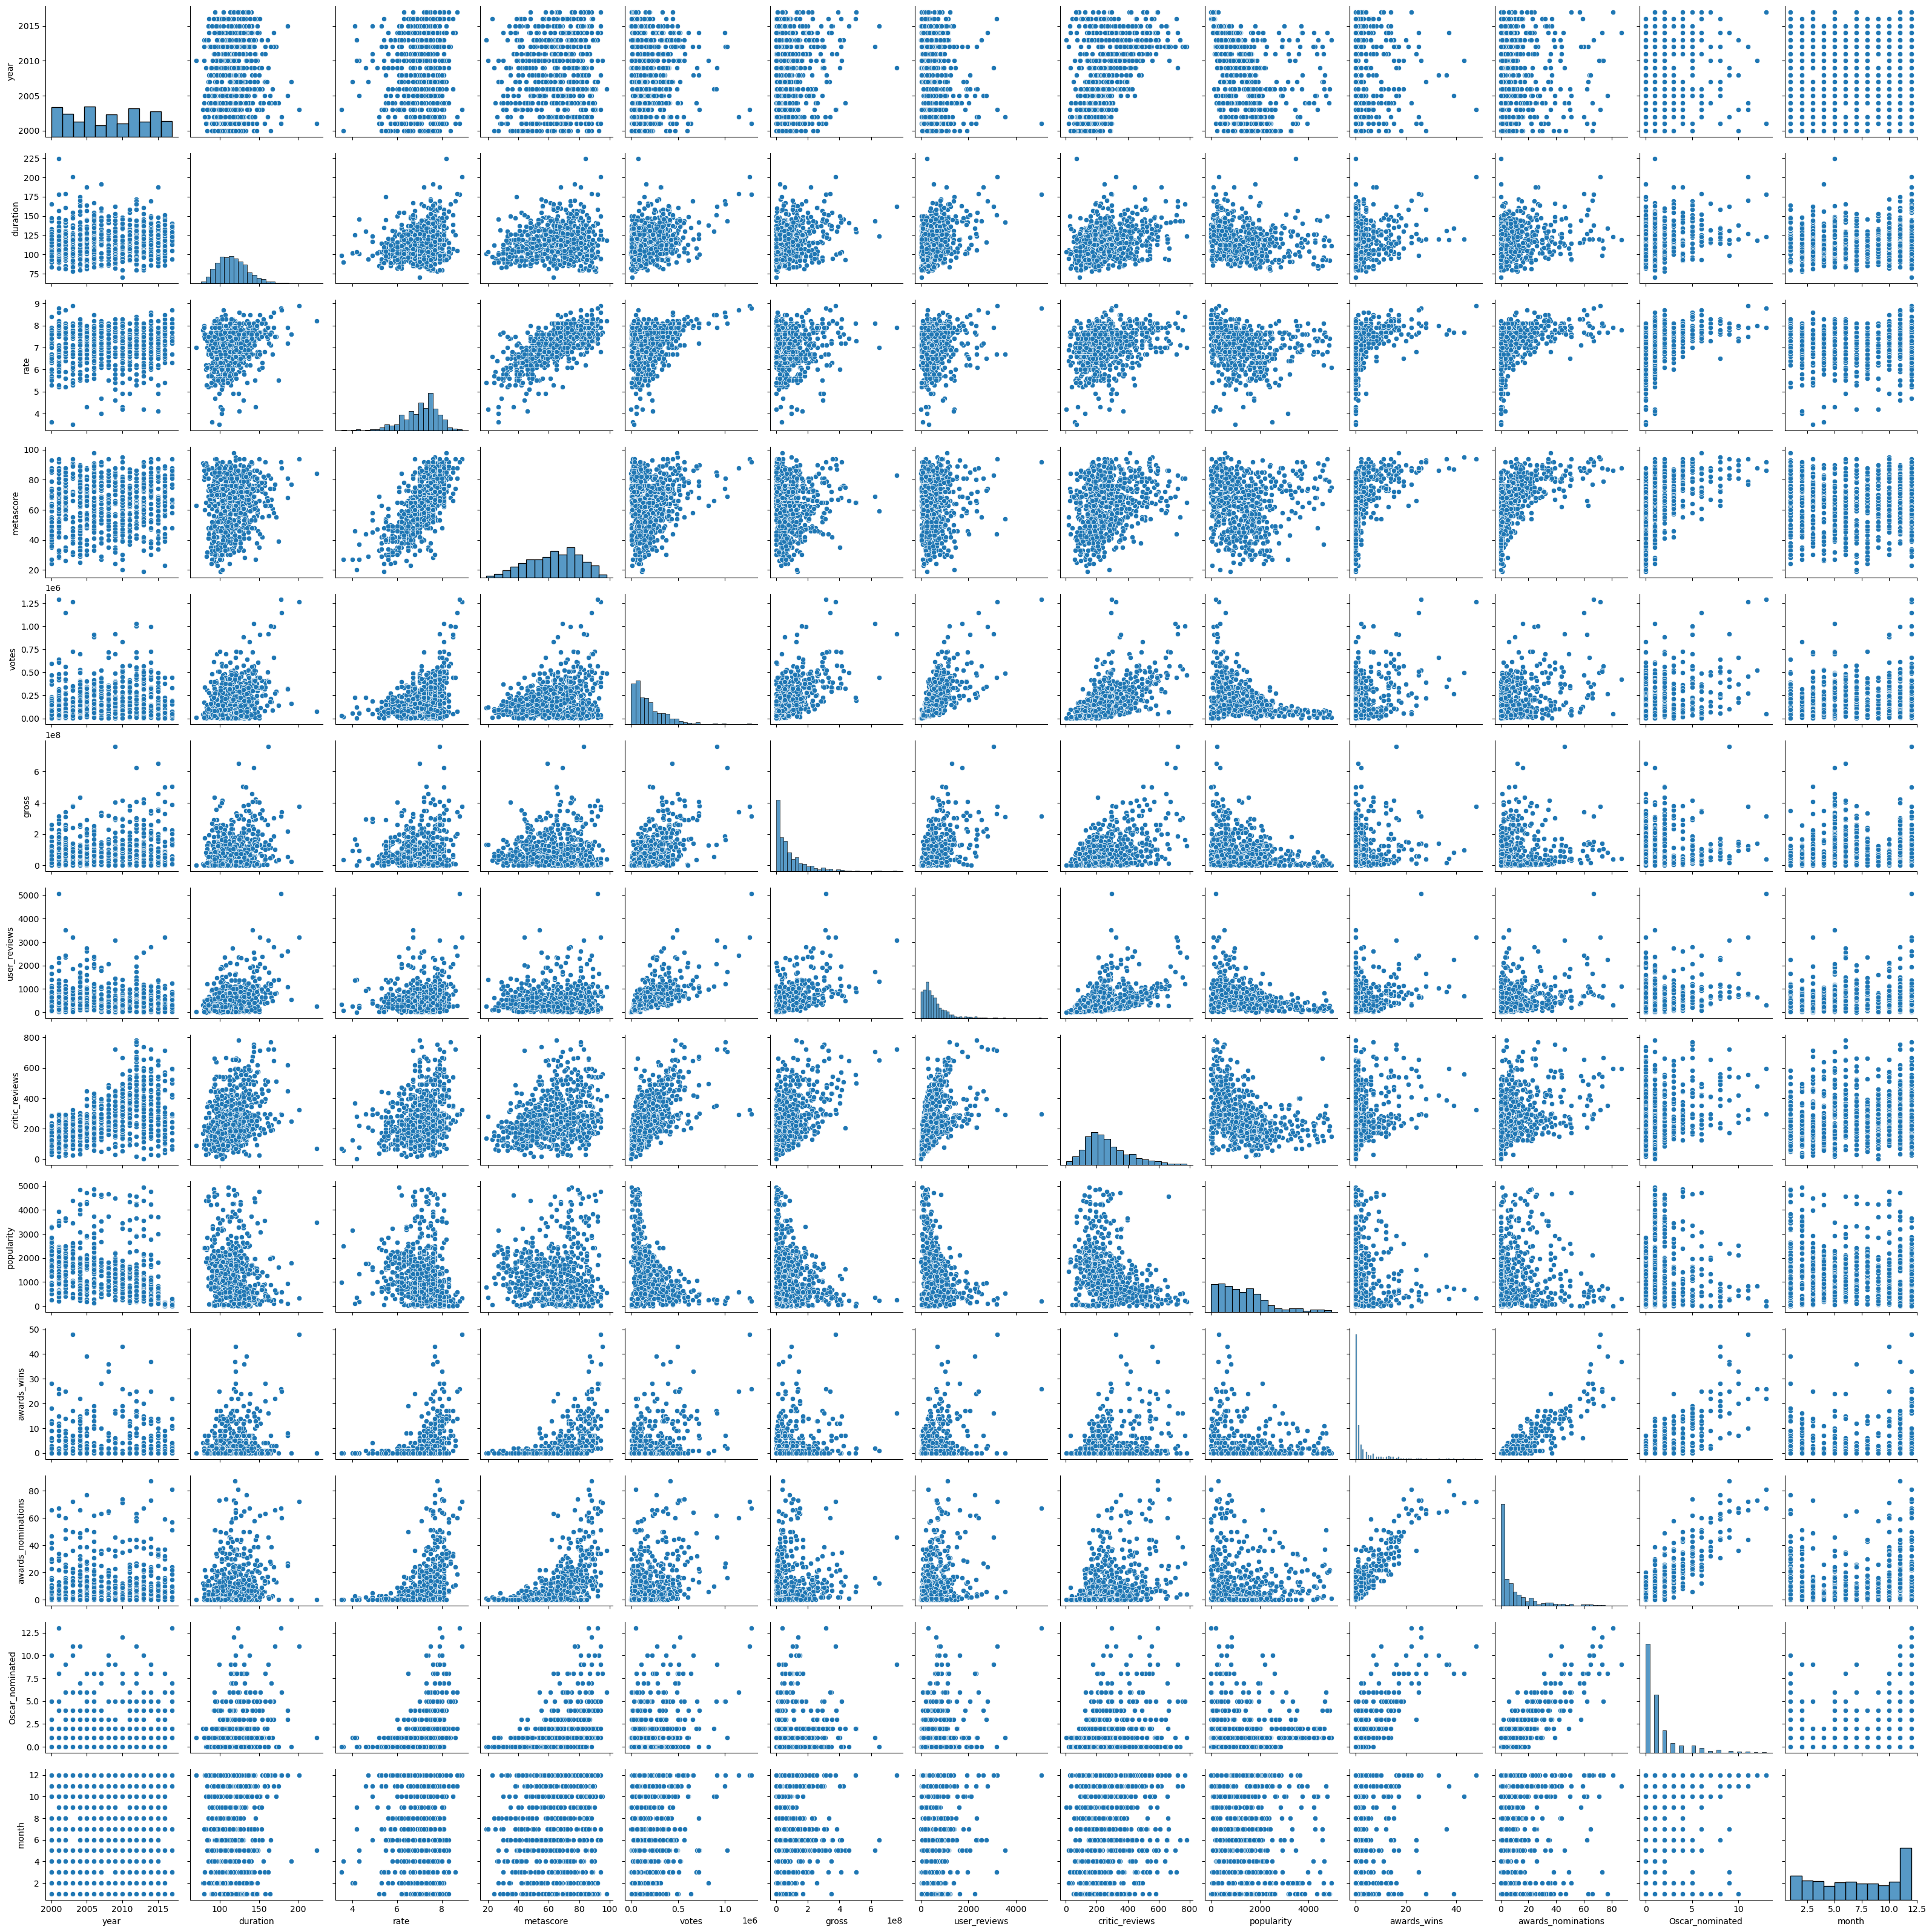

In [5]:
sns.pairplot(train)

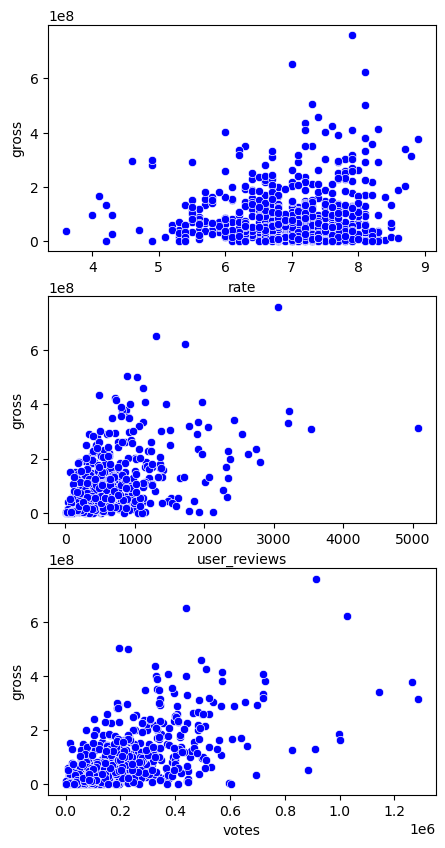

In [6]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(5,10))

sns.scatterplot(ax = axs[0], x = train.rate, y=train.gross, color = 'blue')
sns.scatterplot(ax = axs[1], x = train.user_reviews, y=train.gross, color = 'blue')
sns.scatterplot(ax = axs[2], x = train.votes, y=train.gross, color = 'blue')

plt.show()

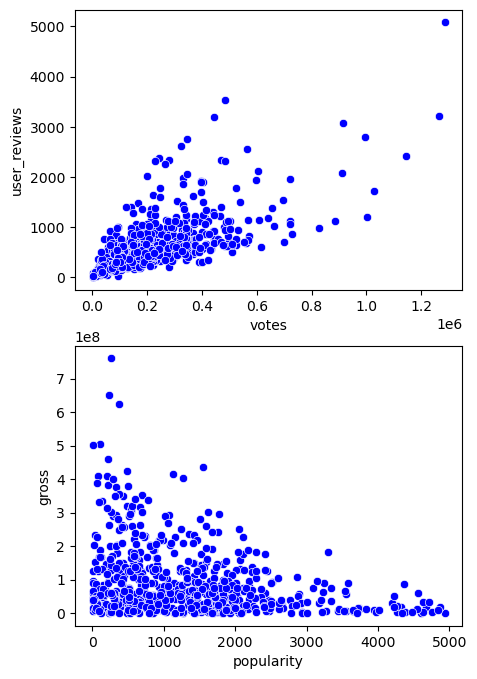

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(5,8))

sns.scatterplot(ax = axs[0], x = train.votes, y=train.user_reviews, color = 'blue')
sns.scatterplot(ax = axs[1], x = train.popularity, y=train.gross, color = 'blue')

plt.show()

In [8]:
# Binning awards_nominations
train.awards_nominations.value_counts()
test.awards_nominations.value_counts()

train['award_noms_binned'] = pd.cut(train['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])
test['award_noms_binned'] = pd.cut(test['awards_nominations'],bins = (-0.001,4,12,30,101),labels = ['Bin1','Bin2','Bin3','Bin4'])


In [9]:
# Model - using votes, user_reviews, rate, certificate, binned awards_nominations
ols_object = smf.ols(formula = 'gross ~ votes * user_reviews + np.exp(rate) + certificate + np.log(popularity) + award_noms_binned', data = train)
og_model = ols_object.fit()
print(og_model.summary())

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     74.57
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          1.30e-105
Time:                        07:44:29   Log-Likelihood:                -12227.
No. Observations:                 629   AIC:                         2.448e+04
Df Residuals:                     617   BIC:                         2.453e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [10]:
pred_gross = og_model.predict(test)
print('RMSE of original model:', np.sqrt(((test['gross'] - pred_gross)**2).mean()))

print("MAE of original model:", (np.abs(test['gross'] - pred_gross)).mean())

# Calculating RSE:
print("RSE of original model: ", np.sqrt(og_model.mse_resid))

RMSE of original model: 69143306.572898
MAE of original model: 45873618.959051386
RSE of original model:  67659978.38983737


In [11]:
# FINDING THE MODEL WITHOUT LEVERAGE POINTS

# Finding outliers and leverage points
#Studentized residuals
out = og_model.outlier_test()

#Computing the leverage statistic for each observation
influence = og_model.get_influence()
leverage = influence.hat_matrix_diag

#Average leverage of points
average_leverage = (og_model.df_model+1)/og_model.nobs

#Number of high leverage points in the dataset
high_leverage_threshold = 4*average_leverage
np.sum(leverage>high_leverage_threshold)

#Dropping influential points from data
influential_index = out.loc[(np.abs(out.student_resid) > 3) & (leverage > high_leverage_threshold), :].index
train_filtered2 = train.drop(influential_index)

In [12]:
ols_object = smf.ols(formula = 'gross ~ votes * user_reviews + np.exp(rate) + certificate + np.log(popularity) + award_noms_binned', data = train_filtered2)
model_filt = ols_object.fit()
print(model_filt.summary())

pred_gross = model_filt.predict(test)
print('RMSE of Model without leverage points:', np.sqrt(((test['gross'] - pred_gross)**2).mean()))

print("MAE of Model without leverage points model:", (np.abs(test['gross'] - pred_gross)).mean())

# Calculating RSE:
print("RSE of Model without leverage points: ", np.sqrt(model_filt.mse_resid))

                            OLS Regression Results                            
Dep. Variable:                  gross   R-squared:                       0.571
Model:                            OLS   Adj. R-squared:                  0.563
Method:                 Least Squares   F-statistic:                     74.32
Date:                Wed, 01 Mar 2023   Prob (F-statistic):          2.99e-105
Time:                        07:44:29   Log-Likelihood:                -12167.
No. Observations:                 627   AIC:                         2.436e+04
Df Residuals:                     615   BIC:                         2.441e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

In [13]:
pred_gross = model_filt.predict(test)
rmse_filt = (np.sqrt(((test['gross'] - pred_gross)**2).mean()))
rmse_filt

69538202.23545401

In [14]:
# Residual plot

sns.scatterplot(x = model_filt.fittedvalues, y=model_filt.resid, color = 'orange')
sns.lineplot(x = [model_filt.fittedvalues.min(), model_filt.fittedvalues.max()], y = [0,0],color = 'blue')
plt.xlabel('Predicted Gross')
plt.ylabel('Residuals')

Text(0, 0.5, 'Residuals')

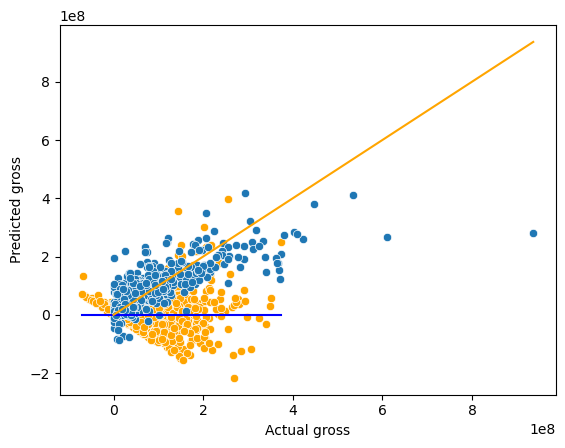

In [15]:
# Plotting predicted gross against real gross to see how close to y=x they are.

sns.scatterplot(x = test.gross, y = pred_gross)
sns.lineplot(x = [0, test.gross.max()], y = [0, test.gross.max()], color = 'orange')
plt.xlabel('Actual gross')
plt.ylabel('Predicted gross')
# Ideally, all points should fall on or close to y = x
plt.show()

In [16]:
# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [17]:
train.isna().sum()
t = train.dropna()

In [18]:
vif_columns = t[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

In [19]:
vif_columns = add_constant(vif_columns)
vif_data = pd.DataFrame()
vif_data['predictor'] = vif_columns.columns
vif_data

,predictor
0,const
1,duration
2,rate
3,metascore
4,votes
5,user_reviews
6,critic_reviews
7,popularity
8,awards_wins
9,awards_nominations


In [20]:
for i in range(len(vif_columns.columns)):
    vif_data.loc[i, 'VIF'] = variance_inflation_factor(vif_columns.values, i)

vif_data

,predictor,VIF
0,const,148.485773
1,duration,1.312286
2,rate,2.598671
3,metascore,2.884364
4,votes,3.032536
5,user_reviews,2.160263
6,critic_reviews,1.822807
7,popularity,1.419425
8,awards_wins,5.066198
9,awards_nominations,6.008127


In [21]:
# SUBSET SELECTION
import itertools
import time
import statsmodels.formula.api as sm

In [22]:
# trying forward stepwise
X = train[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

X_backup = train[['duration', 'rate', 'metascore', 'votes', 'user_reviews', 'critic_reviews',
          'popularity', 'awards_wins', 'awards_nominations', 'month']]

In [23]:
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('gross~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

def forward(predictors):

    # Pull out predictors we still need to process (remaining predictor)
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p])) # adding the remaining predictors one by one to the model
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [24]:
models_best = forward_selection()

Processed  10 models on 1 predictors in 0.031434059143066406 seconds.
Processed  9 models on 2 predictors in 0.029040813446044922 seconds.
Processed  8 models on 3 predictors in 0.03206300735473633 seconds.
Processed  7 models on 4 predictors in 0.034552812576293945 seconds.
Processed  6 models on 5 predictors in 0.028943777084350586 seconds.
Processed  5 models on 6 predictors in 0.02604222297668457 seconds.
Processed  4 models on 7 predictors in 0.024037837982177734 seconds.
Processed  3 models on 8 predictors in 0.018913984298706055 seconds.
Processed  2 models on 9 predictors in 0.01481318473815918 seconds.
Processed  1 models on 10 predictors in 0.008368968963623047 seconds.
Total elapsed time: 0.25897884368896484 seconds.


In [25]:
models_best

,Rsquared,model
1,0.383667,<statsmodels.regression.linear_model.Regressio...
2,0.428223,<statsmodels.regression.linear_model.Regressio...
3,0.454886,<statsmodels.regression.linear_model.Regressio...
4,0.459487,<statsmodels.regression.linear_model.Regressio...
5,0.464948,<statsmodels.regression.linear_model.Regressio...
6,0.468508,<statsmodels.regression.linear_model.Regressio...
7,0.469835,<statsmodels.regression.linear_model.Regressio...
8,0.469841,<statsmodels.regression.linear_model.Regressio...
9,0.469266,<statsmodels.regression.linear_model.Regressio...
10,0.441887,<statsmodels.regression.linear_model.Regressio...


In [26]:
best_sub_plots()

In [27]:
best_fwd_model = models_best.loc[10,'model']
best_fwd_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     48.61
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           2.60e-71
Time:                        07:44:30   Log-Likelihood:                -12233.
No. Observations:                 625   AIC:                         2.449e+04
Df Residuals:                     614   BIC:                         2.454e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.577e+08   3.76e+07      4.195      0.000    8.39e+07    2.32e+08
votes                296.7357     29.548     10.042      0.000     238.708     354.763
rate               -3.266e+07   6.15e+06     -5.315      0.000   -4.47e+07   -2.06e+07
critic_reviews      1.346e+05   2.91e+04      4.628      0.000    7.75e+04    1.92e+05
user_reviews         1.83e+04   8407.762      2.177      0.030    1789.818    3.48e+04
awards_nominations -7.211e+05   4.78e+05     -1.508      0.132   -1.66e+06    2.18e+05
month               9.774e+05   8.56e+05      1.142      0.254   -7.03e+05    2.66e+06
duration            2.623e+05   1.79e+05      1.465      0.143   -8.92e+04    6.14e+05
awards_wins        -4.981e+04   1.12e+06     -0.045      0.964   -2.25e+06    2.15e+06
metascore           3.993e+05   3.12e+05      1.280      0.201   -2.13e+05    1.01e+06
popularity         -1834.5682   3557.266     -0.516      0.606   -8820.452    5151.316
==============================================================================
Omnibus:                      205.300   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              912.131
Skew:                           1.432   Prob(JB):                    8.57e-199
Kurtosis:                       8.180   Cond. No.                     3.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [28]:
# with fwd
pred_gross = best_fwd_model.predict(test)
rmse_fwd_noint = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_fwd_noint

79483673.65365684

In [29]:
# with all
all_model = sm.ols('gross~' + '+'.join(X.columns),data = train).fit()
pred_gross = all_model.predict(test)
rmse_all = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_all

79483673.65365484

In [30]:
# best subset w/o interactions

In [31]:
def getBest_model(k):
    tic = time.time()
    results = []
    for combo in itertools.combinations(X.columns, k): # all subsets of k are evaluated
        results.append(processSubset((list(combo))))

    # Wrap everything up in a dataframe
    models = pd.DataFrame(results)

    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()] # pickingthe best model among subsets w size k using R2
    
    toc = time.time()
    print("Processed", models.shape[0], "models on", k, "predictors in", (toc-tic), "seconds.")
    return best_model

In [32]:
models_best = pd.DataFrame(columns=["Rsquared", "model"])


# using a for loop to loop through and get best model for 1, 2, 3...k predictors
tic = time.time()
for i in range(1,1+X.shape[1]):
    models_best.loc[i] = getBest_model(i)

toc = time.time()
print("Total elapsed time:", (toc-tic), "seconds.")

Processed 10 models on 1 predictors in 0.030762195587158203 seconds.
Processed 45 models on 2 predictors in 0.14042997360229492 seconds.
Processed 120 models on 3 predictors in 0.441605806350708 seconds.
Processed 210 models on 4 predictors in 1.0159611701965332 seconds.
Processed 252 models on 5 predictors in 1.1943449974060059 seconds.
Processed 210 models on 6 predictors in 1.1523337364196777 seconds.
Processed 120 models on 7 predictors in 0.7210109233856201 seconds.
Processed 45 models on 8 predictors in 0.2807939052581787 seconds.
Processed 10 models on 9 predictors in 0.06694793701171875 seconds.
Processed 1 models on 10 predictors in 0.008295059204101562 seconds.
Total elapsed time: 5.071729898452759 seconds.


In [33]:
models_best

,Rsquared,model
1,0.383667,<statsmodels.regression.linear_model.Regressio...
2,0.428223,<statsmodels.regression.linear_model.Regressio...
3,0.454886,<statsmodels.regression.linear_model.Regressio...
4,0.459487,<statsmodels.regression.linear_model.Regressio...
5,0.464948,<statsmodels.regression.linear_model.Regressio...
6,0.468508,<statsmodels.regression.linear_model.Regressio...
7,0.469835,<statsmodels.regression.linear_model.Regressio...
8,0.469841,<statsmodels.regression.linear_model.Regressio...
9,0.469266,<statsmodels.regression.linear_model.Regressio...
10,0.441887,<statsmodels.regression.linear_model.Regressio...


In [34]:
best_sub_plots()

In [35]:
best_subset_model = models_best.loc[10,'model']
best_subset_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.433
Method:                 Least Squares   F-statistic:                     48.61
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           2.60e-71
Time:                        07:44:35   Log-Likelihood:                -12233.
No. Observations:                 625   AIC:                         2.449e+04
Df Residuals:                     614   BIC:                         2.454e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.577e+08   3.76e+07      4.195      0.000    8.39e+07    2.32e+08
duration            2.623e+05   1.79e+05      1.465      0.143   -8.92e+04    6.14e+05
rate               -3.266e+07   6.15e+06     -5.315      0.000   -4.47e+07   -2.06e+07
metascore           3.993e+05   3.12e+05      1.280      0.201   -2.13e+05    1.01e+06
votes                296.7357     29.548     10.042      0.000     238.708     354.763
user_reviews         1.83e+04   8407.762      2.177      0.030    1789.818    3.48e+04
critic_reviews      1.346e+05   2.91e+04      4.628      0.000    7.75e+04    1.92e+05
popularity         -1834.5682   3557.266     -0.516      0.606   -8820.452    5151.316
awards_wins        -4.981e+04   1.12e+06     -0.045      0.964   -2.25e+06    2.15e+06
awards_nominations -7.211e+05   4.78e+05     -1.508      0.132   -1.66e+06    2.18e+05
month               9.774e+05   8.56e+05      1.142      0.254   -7.03e+05    2.66e+06
==============================================================================
Omnibus:                      205.300   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              912.131
Skew:                           1.432   Prob(JB):                    8.57e-199
Kurtosis:                       8.180   Cond. No.                     3.45e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.45e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
# with subset
pred_gross = best_subset_model.predict(test)
rmse_subset_noint = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_subset_noint

79483673.65365484

In [37]:
# fwd with interactions

In [38]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')

In [39]:
for combo in itertools.combinations(X_backup.columns, 2):    
    train['_'.join(combo)] = train[combo[0]]*train[combo[1]]
    test['_'.join(combo)] = test[combo[0]]*test[combo[1]]
    X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)] 

/var/folders/5n/6l3ydvln7pj8bj_k3rx30gdc0000gn/T/ipykernel_56687/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/5n/6l3ydvln7pj8bj_k3rx30gdc0000gn/T/ipykernel_56687/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[:,'_'.join(combo)] = train.loc[:,'_'.join(combo)]
/var/folders/5n/6l3ydvln7pj8bj_k3rx30gdc0000gn/T/ipykernel_56687/1885028967.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy

In [40]:
X.head()

,duration,rate,metascore,votes,user_reviews,critic_reviews,popularity,awards_wins,awards_nominations,month,...,critic_reviews_popularity,critic_reviews_awards_wins,critic_reviews_awards_nominations,critic_reviews_month,popularity_awards_wins,popularity_awards_nominations,popularity_month,awards_wins_awards_nominations,awards_wins_month,awards_nominations_month
357,109,6.8,63.0,159825,1057.0,277.0,836.0,0,1,4.0,...,231572.0,0.0,277.0,1108.0,0.0,836.0,3344.0,0,0.0,4.0
923,112,7.1,72.0,294558,854.0,544.0,1308.0,1,8,6.0,...,711552.0,544.0,4352.0,3264.0,1308.0,10464.0,7848.0,8,6.0,48.0
1019,101,5.4,19.0,111737,262.0,138.0,787.0,0,1,7.0,...,108606.0,0.0,138.0,966.0,0.0,787.0,5509.0,0,0.0,7.0
1059,116,8.3,81.0,131024,709.0,514.0,4.0,6,59,11.0,...,2056.0,3084.0,30326.0,5654.0,24.0,236.0,44.0,354,66.0,649.0
802,137,7.6,73.0,35248,78.0,227.0,2934.0,0,3,3.0,...,666018.0,0.0,681.0,681.0,0.0,8802.0,8802.0,0,0.0,9.0


In [41]:
models_best = forward_selection()

Processed  55 models on 1 predictors in 0.1390061378479004 seconds.
Processed  54 models on 2 predictors in 0.16083788871765137 seconds.
Processed  53 models on 3 predictors in 0.18852615356445312 seconds.
Processed  52 models on 4 predictors in 0.22171807289123535 seconds.
Processed  51 models on 5 predictors in 0.23983192443847656 seconds.
Processed  50 models on 6 predictors in 0.26726508140563965 seconds.
Processed  49 models on 7 predictors in 0.30306005477905273 seconds.
Processed  48 models on 8 predictors in 0.2909281253814697 seconds.
Processed  47 models on 9 predictors in 0.3176138401031494 seconds.
Processed  46 models on 10 predictors in 0.33637094497680664 seconds.
Processed  45 models on 11 predictors in 0.35246801376342773 seconds.
Processed  44 models on 12 predictors in 0.3692028522491455 seconds.
Processed  43 models on 13 predictors in 0.3827838897705078 seconds.
Processed  42 models on 14 predictors in 0.5014781951904297 seconds.
Processed  41 models on 15 predicto

In [42]:
best_sub_plots()

In [43]:
best_fwd_inter_model = models_best.loc[46,'model']
best_fwd_inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.575
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     17.02
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           5.34e-80
Time:                        07:44:55   Log-Likelihood:                -12148.
No. Observations:                 625   AIC:                         2.439e+04
Df Residuals:                     578   BIC:                         2.460e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Intercept                          -2.06e+08   2.24e+08     -0.921      0.357   -6.45e+08    2.33e+08
votes_critic_reviews                 -0.1580      0.181     -0.871      0.384      -0.514       0.198
rate                               5.004e+07   4.04e+07      1.237      0.216   -2.94e+07    1.29e+08
votes                              2173.3381    340.014      6.392      0.000    1505.525    2841.151
rate_votes                         -361.0474     49.751     -7.257      0.000    -458.762    -263.333
duration_votes                        2.3765      1.537      1.546      0.123      -0.642       5.395
metascore_votes                       9.5946      2.891      3.318      0.001       3.916      15.274
awards_wins_awards_nominations    -1.288e+05    3.7e+04     -3.486      0.001   -2.01e+05   -5.62e+04
rate_awards_wins                   1.028e+06   2.83e+06      0.363      0.717   -4.54e+06    6.59e+06
duration_metascore                  1.72e+04   1.61e+04      1.069      0.285   -1.44e+04    4.88e+04
duration_month                     2390.2269   4.75e+04      0.050      0.960    -9.1e+04    9.58e+04
user_reviews_awards_wins             41.9142   3540.803      0.012      0.991   -6912.494    6996.322
votes_month                           4.5904      8.300      0.553      0.580     -11.712      20.893
metascore_awards_wins              2.232e+05   1.37e+05      1.628      0.104    -4.6e+04    4.92e+05
votes_awards_nominations             -5.4218      3.705     -1.463      0.144     -12.699       1.856
metascore_critic_reviews          -8022.1489   2844.372     -2.820      0.005   -1.36e+04   -2435.584
rate_critic_reviews                 3.01e+05    6.1e+04      4.936      0.000    1.81e+05    4.21e+05
critic_reviews                    -1.547e+06   3.61e+05     -4.280      0.000   -2.26e+06   -8.37e+05
metascore                         -1.786e+06   2.73e+06     -0.653      0.514   -7.16e+06    3.58e+06
awards_wins                       -7.485e+06   2.31e+07     -0.323      0.746   -5.29e+07     3.8e+07
votes_awards_wins                    12.9018      8.565      1.506      0.133      -3.920      29.724
awards_nominations                  2.12e+07   8.33e+06      2.546      0.011    4.85e+06    3.76e+07
rate_awards_nominations           -1.885e+06   1.05e+06     -1.789      0.074   -3.96e+06    1.85e+05
votes_user_reviews                    0.0370      0.034      1.076      0.282      -0.031       0.105
metascore_awards_nominations      -1.162e+05   4.92e+04     -2.363      0.018   -2.13e+05   -1.96e+04
rate_user_reviews                 -1.502e+04   1.47e+04     -1.025      0.306   -4.38e+04    1.38e+04
user_reviews_critic_reviews          79.9642     57.132      1.400      0.162     -32.248     192.177
duration_awards_wins   

In [44]:
pred_gross = best_fwd_inter_model.predict(test)
rmse_fwd_int = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_fwd_int

78580477.72403665

In [45]:
# backward w/ interactions
X.head()

,duration,rate,metascore,votes,user_reviews,critic_reviews,popularity,awards_wins,awards_nominations,month,...,critic_reviews_popularity,critic_reviews_awards_wins,critic_reviews_awards_nominations,critic_reviews_month,popularity_awards_wins,popularity_awards_nominations,popularity_month,awards_wins_awards_nominations,awards_wins_month,awards_nominations_month
357,109,6.8,63.0,159825,1057.0,277.0,836.0,0,1,4.0,...,231572.0,0.0,277.0,1108.0,0.0,836.0,3344.0,0,0.0,4.0
923,112,7.1,72.0,294558,854.0,544.0,1308.0,1,8,6.0,...,711552.0,544.0,4352.0,3264.0,1308.0,10464.0,7848.0,8,6.0,48.0
1019,101,5.4,19.0,111737,262.0,138.0,787.0,0,1,7.0,...,108606.0,0.0,138.0,966.0,0.0,787.0,5509.0,0,0.0,7.0
1059,116,8.3,81.0,131024,709.0,514.0,4.0,6,59,11.0,...,2056.0,3084.0,30326.0,5654.0,24.0,236.0,44.0,354,66.0,649.0
802,137,7.6,73.0,35248,78.0,227.0,2934.0,0,3,3.0,...,666018.0,0.0,681.0,681.0,0.0,8802.0,8802.0,0,0.0,9.0


In [46]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [47]:
models_best = backward_selection()

Processed  55 models on 54 predictors in 1.8058388233184814 seconds.
Processed  54 models on 53 predictors in 1.8212370872497559 seconds.
Processed  53 models on 52 predictors in 1.682697057723999 seconds.
Processed  52 models on 51 predictors in 1.6945149898529053 seconds.
Processed  51 models on 50 predictors in 1.575873851776123 seconds.
Processed  50 models on 49 predictors in 1.6768040657043457 seconds.
Processed  49 models on 48 predictors in 1.5060241222381592 seconds.
Processed  48 models on 47 predictors in 1.4261069297790527 seconds.
Processed  47 models on 46 predictors in 1.3793132305145264 seconds.
Processed  46 models on 45 predictors in 1.4362471103668213 seconds.
Processed  45 models on 44 predictors in 1.261324167251587 seconds.
Processed  44 models on 43 predictors in 1.2413501739501953 seconds.
Processed  43 models on 42 predictors in 1.180420160293579 seconds.
Processed  42 models on 41 predictors in 1.1189911365509033 seconds.
Processed  41 models on 40 predictors 

In [48]:
best_sub_plots()

In [49]:
best_bck_inter_model = models_best.loc[15,'model']
best_bck_inter_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  gross   R-squared:                       0.547
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     49.05
Date:                Wed, 01 Mar 2023   Prob (F-statistic):           2.87e-94
Time:                        07:45:32   Log-Likelihood:                -12168.
No. Observations:                 625   AIC:                         2.437e+04
Df Residuals:                     609   BIC:                         2.444e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                       -3.47e+07   1.31e+07     -2.639      0.009   -6.05e+07   -8.88e+06
votes                           2598.4720    253.216     10.262      0.000    2101.190    3095.754
critic_reviews                 -9.224e+05   2.25e+05     -4.099      0.000   -1.36e+06    -4.8e+05
popularity                      7.572e+04      2e+04      3.793      0.000    3.65e+04    1.15e+05
awards_nominations              1.879e+07   3.95e+06      4.755      0.000     1.1e+07    2.65e+07
month                            5.18e+05   7.81e+05      0.664      0.507   -1.02e+06    2.05e+06
rate_votes                      -394.0521     38.608    -10.207      0.000    -469.873    -318.232
rate_critic_reviews             2.096e+05    3.5e+04      5.981      0.000    1.41e+05    2.78e+05
rate_popularity                -8636.8380   2901.462     -2.977      0.003   -1.43e+04   -2938.753
rate_awards_nominations        -2.348e+06   5.15e+05     -4.558      0.000   -3.36e+06   -1.34e+06
metascore_votes                    9.4346      2.037      4.631      0.000       5.434      13.436
metascore_critic_reviews       -6834.2806   1705.415     -4.007      0.000   -1.02e+04   -3485.073
votes_user_reviews                 0.0490      0.013      3.726      0.000       0.023       0.075
votes_awards_wins                  9.9872      2.297      4.348      0.000       5.477      14.498
critic_reviews_popularity        -69.8994     24.242     -2.883      0.004    -117.508     -22.291
awards_wins_awards_nominations -1.029e+05   2.04e+04     -5.047      0.000   -1.43e+05   -6.29e+04
==============================================================================
Omnibus:                      185.875   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              677.622
Skew:                           1.355   Prob(JB):                    7.18e-148
Kurtosis:                       7.321   Cond. No.                     2.23e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.23e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [50]:
pred_gross = best_bck_inter_model.predict(test)
rmse_bck_int = np.sqrt(((pred_gross - test.gross)**2).mean())
rmse_bck_int

77698578.61052634

In [51]:
rmse_df = pd.DataFrame({
    'Model' : ['Forward (No Int)', 'Subset (No Int)', 'Forward (Int)', 'Backward (Int)', 'Bin Model', 'All Preds'],
    'rmse' : [rmse_fwd_noint, rmse_subset_noint, rmse_fwd_int, rmse_bck_int, rmse_filt, rmse_all],
    'Adj_R2' : [best_fwd_model.rsquared_adj, best_subset_model.rsquared_adj, best_fwd_inter_model.rsquared_adj,
               best_bck_inter_model.rsquared_adj, model_filt.rsquared_adj, all_model.rsquared_adj]
})

rmse_df

,Model,rmse,Adj_R2
0,Forward (No Int),7.948367e+07,0.432797
1,Subset (No Int),7.948367e+07,0.432797
2,Forward (Int),7.858048e+07,0.541465
3,Backward (Int),7.769858e+07,0.535967
4,Bin Model,6.953820e+07,0.563024
5,All Preds,7.948367e+07,0.432797
